# vdl Depth and Class Constrained Diffusion
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

## Dataset Preparation

- 894 classes -> 18 classes

In [4]:
from data.nyuv2 import NYUDepthV2
from torchvision import transforms
from torch.utils.data import DataLoader

image_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
])

crop_t = transforms.Compose([
    transforms.CenterCrop(400)
])

dataset = NYUDepthV2(root='data', 
                     download=True, 
                     preload=False, 
                     image_transform=image_t, 
                     seg_transform=crop_t, 
                     depth_transform=crop_t, 
                     filtered_classes=[5, 11, 21, 26, 2, 3, 7, 64, 144, 19, 119, 157, 28, 55, 15, 59, 4, 83])

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Dataset already exists, skipping download.


In [5]:
from torch.utils.data import Subset
import numpy as np

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_seed=42):
    """
    Splits the dataset into train, validation, and test partitions.

    :param dataset: The NYUDepthV2 dataset object.
    :param train_ratio: Proportion of the dataset to allocate to the training set.
    :param val_ratio: Proportion of the dataset to allocate to the validation set.
    :param test_ratio: Proportion of the dataset to allocate to the test set.
    :param random_seed: Seed for reproducibility of the split.
    :return: A tuple of (train_dataset, val_dataset, test_dataset).
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    # Set random seed for reproducibility
    np.random.seed(random_seed)
    
    # Total size of the dataset
    total_size = len(dataset)
    indices = np.arange(total_size)
    
    # Shuffle the indices
    np.random.shuffle(indices)
    
    # Calculate split points
    train_split = int(train_ratio * total_size)
    val_split = train_split + int(val_ratio * total_size)
    
    # Split the indices
    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]
    
    # Create dataset subsets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)
    
    return train_dataset, val_dataset, test_dataset

In [6]:
import torch
import matplotlib.pyplot as plt

def unnormalize(img):
    mean = torch.tensor([1.3268, 1.1391, 1.0176]).view(-1, 1, 1)  # Reshape to [C, 1, 1]
    std = torch.tensor([0.5704, 0.5411, 0.5077]).view(-1, 1, 1)    # Reshape to [C, 1, 1]
    img = std * img + mean
    img = torch.clip(img, 0, 1)
    return img

dataset[0][4].shape

(18,)

## Modules

In [7]:
from core import UNet_Baseline

# Instantiate the model
net = UNet_Baseline(num_classes=18, device="cuda").to("cuda")
print(f"Total parameters: {sum(p.numel() for p in net.parameters())}")

# Dummy inputs
x = torch.randn(1, 3, 64, 64).to("cuda")
t = torch.randint(0, 1000, (x.shape[0],)).to("cuda")
class_vector = torch.ones((x.shape[0], 18)).to("cuda")
depth_vector = torch.zeros((x.shape[0], 18)).to("cuda")

# Forward pass
output = net(x, t, class_vector, depth_vector)
print(f"Output shape: {output.shape}")


Total parameters: 1771907
Output shape: torch.Size([1, 3, 64, 64])


## Diffusion

In [8]:
import os
import copy
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from torch import optim
import logging

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.device = device

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        epsilon = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon, epsilon

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n, class_vectors=None, depth_vectors=None, cfg_scale=0):
        logging.info(f"Sampling {n} new images....")
        model.eval()

        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                
                current_class_vectors = class_vectors if class_vectors is not None else None
                current_depth_vectors = depth_vectors if depth_vectors is not None else None
              
                predicted_noise = model(x, t, current_class_vectors, current_depth_vectors)
                
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

## Trainer

In [28]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import copy
import os
import wandb
from core import EMA
import logging

logger = logging.getLogger(__name__)

import torch
import torch.nn.functional as F
import copy
import os
import wandb
from core import EMA
import logging

logger = logging.getLogger(__name__)

class Trainer:
    def __init__(self, model, diffusion, optimizer, epochs, device, train_dataloader, val_dataloader=None, 
                 run_name='diffusion_model', project_name='diffusion_project', save_dir='models', ema_decay=0.995, 
                 sample_images_every=100, resolved_names=None, scheduler=None):
        self.model = model.to(device)
        self.diffusion = diffusion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.device = device
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.run_name = run_name
        self.project_name = project_name
        self.save_dir = save_dir
        self.ema_decay = ema_decay
        self.resolved_names = resolved_names

        # Initialize EMA
        self.ema = EMA(ema_decay)
        self.ema_model = copy.deepcopy(model).eval().requires_grad_(False)

        # Initialize Weights & Biases
        wandb.init(project=self.project_name, name=self.run_name)
        self.run_id = wandb.run.id
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.sample_images_every = sample_images_every

        # Create a models directory if it doesn't exist
        os.makedirs(self.save_dir, exist_ok=True)

    def _train_epoch(self):
        self.model.train()
        epoch_loss = 0.0

        for images, segments, depths, class_vectors, depth_vectors in self.train_dataloader:
            images = images.to(self.device)
            class_vectors = class_vectors.to(self.device)
            depth_vectors = depth_vectors.to(self.device)

            # Sample time steps
            t = self.diffusion.sample_timesteps(images.size(0)).to(self.device)

            # Add noise to images
            x_t, noise = self.diffusion.noise_images(images, t)

            # Predict noise using the model
            predicted_noise = self.model(x_t, t, class_vectors, depth_vectors)

            # Compute loss
            loss = F.mse_loss(predicted_noise, noise)

            # Backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Update EMA model
            self.ema.step_ema(self.ema_model, self.model)

            epoch_loss += loss.item()

        # Step the scheduler if it's provided
        if self.scheduler:
            self.scheduler.step()

        avg_loss = epoch_loss / len(self.train_dataloader)
        return avg_loss

    def _validate_epoch(self):
        self.model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for images, segments, depths, class_vectors, depth_vectors in self.val_dataloader:
                images = images.to(self.device)
                class_vectors = class_vectors.to(self.device)
                depth_vectors = depth_vectors.to(self.device)

                t = self.diffusion.sample_timesteps(images.size(0)).to(self.device)
                x_t, noise = self.diffusion.noise_images(images, t)

                predicted_noise = self.model(x_t, t, class_vectors, depth_vectors)
                loss = F.mse_loss(predicted_noise, noise)

                val_loss += loss.item()

        avg_val_loss = val_loss / len(self.val_dataloader)
        return avg_val_loss

    def _save_model(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            model_name = f"{self.run_name}_{self.run_id}.pth"
            save_path = os.path.join(self.save_dir, model_name)
            torch.save(self.model.state_dict(), save_path)
            torch.save(self.ema_model.state_dict(), save_path.replace(".pth", "_ema.pth"))
            logger.info(f"Models saved to {self.save_dir} with val_loss {val_loss:.4f}")

    def _plot_samples(self, n=5, n_present_classes=3, depth_lower=0.1, depth_upper=3.0):
        indices = torch.stack([torch.randperm(18)[:n_present_classes] for _ in range(n)])
        class_vectors = torch.zeros((n, 18)).to(self.device)
        rows = torch.arange(n).unsqueeze(1)
        class_vectors[rows, indices] = 1
        
        depth_vectors = torch.rand(n, 18).to(self.device) * depth_upper + depth_lower
        
        class_labels = []
        for i in range(n):
            indices = torch.where(class_vectors[i] == 1)[0].tolist()
            labels = [(self.resolved_names[idx], depth_vectors[i, idx].item()) for idx in indices]
            class_labels.append(labels)

        default_sampled_images = self.diffusion.sample(self.model, n=n, class_vectors=class_vectors, depth_vectors=depth_vectors)
        ema_sampled_images = self.diffusion.sample(self.ema_model, n=n, class_vectors=class_vectors, depth_vectors=depth_vectors)
        
        fig_default, axes_default = plt.subplots(1, n, figsize=(n * 3, 3))
        for i, ax in enumerate(axes_default):
            img = default_sampled_images[i].permute(1, 2, 0).cpu().numpy()
            ax.imshow(img)
            ax.axis('off')
            ax.set_title("\n".join([f"{cls}: {depth:.2f}" for cls, depth in class_labels[i]]), fontsize=8)
        fig_default.tight_layout()
        plt.close(fig_default)

        fig_ema, axes_ema = plt.subplots(1, n, figsize=(n * 3, 3))
        for i, ax in enumerate(axes_ema):
            img = ema_sampled_images[i].permute(1, 2, 0).cpu().numpy()
            ax.imshow(img)
            ax.axis('off')
            ax.set_title("\n".join([f"{cls}: {depth:.2f}" for cls, depth in class_labels[i]]), fontsize=8)
        fig_ema.tight_layout()
        plt.close(fig_ema)
        
        wandb.log({"Default Model Samples": wandb.Image(fig_default),
                   "EMA Model Samples": wandb.Image(fig_ema)})

    def run(self):
        for epoch in range(self.epochs):
            logger.info(f"Epoch {epoch + 1}/{self.epochs}")
            
            current_lr = self.optimizer.param_groups[0]['lr']

            train_loss = self._train_epoch()
            val_loss = self._validate_epoch()
            
            wandb.log({"epoch": epoch + 1,
                       "train_loss": train_loss,
                       "val_loss": val_loss,
                       "learning_rate": current_lr})
            
            logger.info(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
            
            if epoch % self.sample_images_every == 0:
                self._plot_samples()

            self._save_model(val_loss)

    def test(self, test_dataloader):
        self.model.eval()
        test_loss = 0.0

        with torch.no_grad():
            for images, segments, depths, class_vectors, depth_vectors in test_dataloader:
                images = images.to(self.device)
                class_vectors = class_vectors.to(self.device)
                depth_vectors = depth_vectors.to(self.device)

                t = self.diffusion.sample_timesteps(images.size(0)).to(self.device)
                x_t, noise = self.diffusion.noise_images(images, t)

                predicted_noise = self.model(x_t, t, class_vectors, depth_vectors)
                loss = F.mse_loss(predicted_noise, noise)

                test_loss += loss.item()

        avg_test_loss = test_loss / len(test_dataloader)
        logger.info(f"Test Loss: {avg_test_loss:.4f}")
        wandb.log({"test_loss": avg_test_loss})

In [30]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[:24], train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training samples: 16
Validation samples: 4
Testing samples: 4


In [31]:
epochs = 1000
batch_size = 1
learning_rate = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

#train_loader = DataLoader(dataset[:1], batch_size=batch_size, shuffle=True, num_workers=0)

# Initialize model
num_classes = 18
model = UNet_Baseline(num_classes=num_classes, device=device)

# Initialize diffusion process
diffusion = Diffusion(noise_steps=1000, beta_start=0.0001, beta_end=0.002, img_size=64, device="cuda")

# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Initialize trainer
trainer = Trainer(
    model=model,
    diffusion=diffusion,
    optimizer=optimizer,
    epochs=epochs,
    device=device,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    run_name='nyu_depth_diffusion',
    project_name='vdl',
    save_dir='models',
    resolved_names=dataset.resolved_names,
    scheduler=scheduler
)

trainer.run()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: okaynils. Use `wandb login --relogin` to force relogin


05:33:41 - INFO: Epoch 1/1000
05:33:42 - INFO: Train Loss: 1.1340, Val Loss: 1.0832
05:33:42 - INFO: Sampling 5 new images....
999it [00:10, 93.38it/s] 
05:33:53 - INFO: Sampling 5 new images....
999it [00:09, 102.01it/s]
05:34:03 - INFO: Models saved to models with val_loss 1.0832
05:34:03 - INFO: Epoch 2/1000
05:34:03 - INFO: Train Loss: 1.0615, Val Loss: 1.0245
05:34:03 - INFO: Models saved to models with val_loss 1.0245
05:34:03 - INFO: Epoch 3/1000
05:34:04 - INFO: Train Loss: 1.0029, Val Loss: 0.9849
05:34:04 - INFO: Models saved to models with val_loss 0.9849
05:34:04 - INFO: Epoch 4/1000
05:34:04 - INFO: Train Loss: 0.9686, Val Loss: 0.9692
05:34:04 - INFO: Models saved to models with val_loss 0.9692
05:34:04 - INFO: Epoch 5/1000
05:34:04 - INFO: Train Loss: 0.9560, Val Loss: 0.9334
05:34:04 - INFO: Models saved to models with val_loss 0.9334
05:34:04 - INFO: Epoch 6/1000
05:34:04 - INFO: Train Loss: 0.9153, Val Loss: 0.9378
05:34:04 - INFO: Epoch 7/1000
05:34:04 - INFO: Train 

In [45]:
trainer.test(test_loader)

06:26:37 - INFO: Test Loss: 0.0548


In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Baseline(num_classes=18).to(device)
model.load_state_dict(torch.load('models/nyu_depth_diffusion_n37e0cx8_ema.pth', map_location=torch.device(device)))

C:\Users\fahrn\AppData\Local\Temp\ipykernel_8384\862176638.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/nyu_depth_diffusion_n

<All keys matched successfully>

In [39]:
# a 894-dimensional class vector with some 1s and 0s
class_vector = torch.tensor(dataset[0][3]).unsqueeze(0)
depth_vector = torch.tensor(dataset[0][4]).unsqueeze(0)

In [40]:
class_vector.shape, depth_vector.shape

(torch.Size([1, 18]), torch.Size([1, 18]))

In [41]:
diffusion = Diffusion(noise_steps=1000, beta_start=0.0001, beta_end=0.002, img_size=64, device="cuda")

sampled_images = diffusion.sample(model, 1, torch.tensor(dataset[0][3]).unsqueeze(0).to(device), torch.tensor(dataset[0][4]).unsqueeze(0).to(device))

06:02:49 - INFO: Sampling 1 new images....
999it [00:05, 194.35it/s]


In [42]:
sampled_images.shape

torch.Size([1, 3, 64, 64])

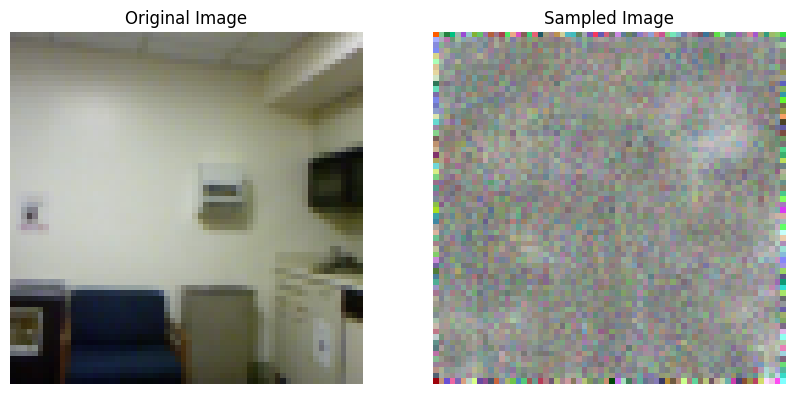

In [44]:
# plot the sampled image next to the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.imshow(dataset[0][0].permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sampled_images[0].cpu().permute(1, 2, 0))
plt.title('Sampled Image')
plt.axis('off')

plt.show()